In [ ]:
# script to replace the base mechanism with new reactions (every reaction calculated) and species (all species calculated for now)

In [2]:
import os
import datetime
import subprocess
import numpy as np

import rmgpy.chemkin
import rmgpy.data.kinetics
# import cantera as ct


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    if type(rxns) != list:
        rxns = [rxns]
    
    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log(k))

    if labels:
        plt.legend(labels)
    plt.show()

In [10]:
def plot_thermos(thermos, labels=None):
    %matplotlib inline
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 3000, 1001)
    for thermo in thermos:
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H)
        ax[1].plot(T, S)
        ax[2].plot(T, Cp)
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [16]:
# Load the base model
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/rmg_model'
new_model_dir = '/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)



In [6]:
# Load the new kinetics library
DFT_DIR = "/work/westgroup/harris.se/autoscience/autoscience/butane/dft/"
kinetics_lib = os.path.join(DFT_DIR, 'kinetics', 'kinetics')
ark_kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
ark_kinetics_database.load_libraries(kinetics_lib)

In [6]:
# stitch each of the library reactions into the mechanism (depends on library index matching indexing in chemkin file)
for key in ark_kinetics_database.libraries[''].entries.keys():
    entry = ark_kinetics_database.libraries[''].entries[key]
    index = entry.index
#     print(index, '\t', entry.label, '\t', reaction_list[index])
    
    if entry.item.is_isomorphic(reaction_list[entry.index]):
        rmg_rxn_index = entry.index
    else:
        print('Library reaction index does not match chemkin index')
        for i, reaction in enumerate(reaction_list):
            if entry.item.is_isomorphic(reaction):
                rmg_rxn_index = i
                break
        else:
            raise ValueError ('could not match reaction index')
          
    # change every possible reaction
    print(f'changing reaction {rmg_rxn_index} {reaction_list[rmg_rxn_index]}')
    reaction_list[rmg_rxn_index].kinetics = entry.data
        
#     print(f'Changing reaction {rmg_rxn_index}')
#     if rmg_rxn_index == 749:
#         plot_kinetics([reaction_list[rmg_rxn_index], entry.data], ['RMG', 'DFT'])
#         reaction_list[rmg_rxn_index].kinetics = entry.data
#     break
    # compare the kinetics
#     plot_kinetics([reaction_list[rmg_rxn_index], entry.data], ['RMG', 'DFT'])
    

changing reaction 18 HO2(16) + HO2(16) <=> O2(2) + H2O2(17)
changing reaction 127 OH(15) + CH2O(9) <=> H2O(8) + HCO(19)
changing reaction 180 H2(13) + CH(3) <=> H(14) + CH2(23)
changing reaction 211 H2O2(17) + C2H3(22) <=> HO2(16) + C2H4(11)
changing reaction 247 OH(15) + butane(1) <=> H2O(8) + SC4H9(183)
changing reaction 278 O2(2) + SC4H9(183) <=> HO2(16) + C4H8-2(189)
changing reaction 288 OH(15) + butane(1) <=> H2O(8) + PC4H9(182)
changing reaction 313 O2(2) + PC4H9(182) <=> HO2(16) + C4H8-1(188)
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 591 CH3CHO(35) + C3H5-A(94) <=> CH3CO(20) + C3H6(12)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)


# 

In [8]:
# Load the new thermo library
thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
ark_thermo_database.load_libraries(thermo_lib)
print(f'{len(ark_thermo_database.libraries["harris_butane"].entries)} entries')

82 entries


ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 79: C[C]C(689)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=689, label="C[C]C", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[2.92363,0.0210869,-1.82385e-06,-5.35961e-09,1.86099e-12,37101.5,19.8374], Tmin=(100,'K'), Tmax=(1330.24,'K')), NASAPolynomial(coeffs=[5.20763,0.0205523,-8.36245e-06,1.49635e-09,-1.00129e-13,35933.5,6.06055], Tmin=(1330.24,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(Cs-CsHHH) + group(Cs-CsHHH) + group(CsJ2_singlet-CsH)"""), molecule=[Molecule(smiles="C[C]C")], transport_data=TransportData(shapeIndex=2, epsilon=(1971.36,'J/mol'), sigma=(5.118,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with fixed Lennard Jones Parameters. This is the fallback method! Try improving transport databases!"""), molecular_weight=(42.0798,'amu'))

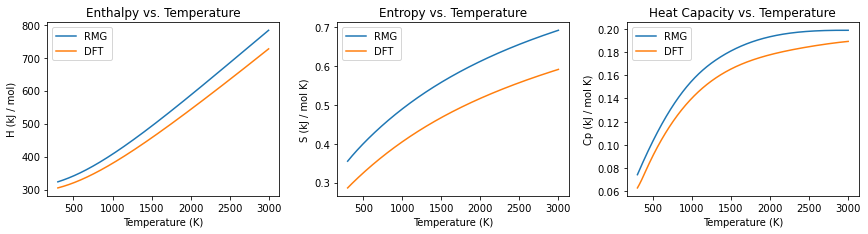

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 83: C[C]CC-2(776)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=776, label="C[C]CC-2", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[2.23551,0.0362128,-1.62669e-05,2.77196e-09,-6.63855e-14,34266.3,25.257], Tmin=(100,'K'), Tmax=(1802.42,'K')), NASAPolynomial(coeffs=[10.5025,0.0226353,-8.93629e-06,1.52848e-09,-9.75154e-14,30511.6,-21.6455], Tmin=(1802.42,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(Cs-CsCsHH) + group(Cs-CsHHH) + group(Cs-CsHHH) + group(CsJ2_singlet-CsH)"""), molecule=[Molecule(smiles="C[C]CC")], transport_data=TransportData(shapeIndex=2, epsilon=(4418.31,'J/mol'), sigma=(4.687,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with fixed Lennard Jones Parameters. This is the fallback method! Try improving transport databases!"""), molecular_weight=(56.1063,'amu'))

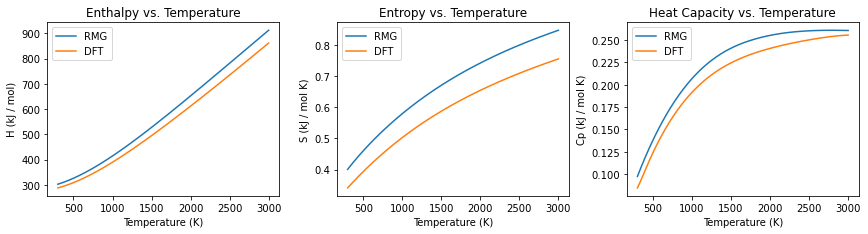

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 85: CC(CCOO)OO(787)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=787, label="CC(CCOO)OO", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[0.0298377,0.0931369,-9.82325e-05,5.84404e-08,-1.46145e-11,-39983.8,30.4602], Tmin=(100,'K'), Tmax=(949.21,'K')), NASAPolynomial(coeffs=[11.6606,0.0441237,-2.07772e-05,4.03962e-09,-2.86276e-13,-42191.7,-25.045], Tmin=(949.21,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(O2s-OsH) + group(O2s-OsH) + group(Cs-CsCsOsH) + group(Cs-CsCsHH) +
group(Cs-CsOsHH) + group(Cs-CsHHH)"""), molecule=[Molecule(smiles="CC(CCOO)OO")], transport_data=TransportData(shapeIndex=2, epsilon=(4363.18,'J/mol'), sigma=(7.265,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=681.52 K, Pc=25.82 bar (from Joback method)"""), molecular_weight=(122.12,'amu'))

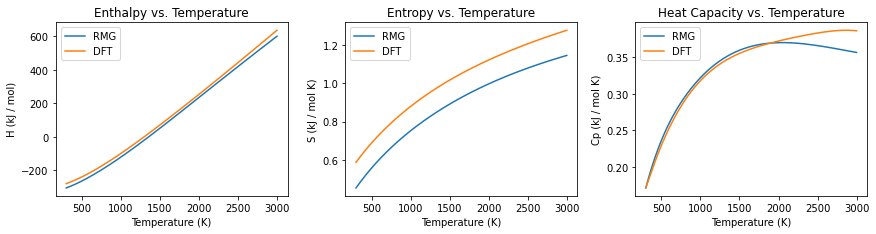

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 88: O=C1COC1(917)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=917, label="O=C1COC1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[2.97507,0.00701326,6.36235e-05,-8.78507e-08,3.37574e-11,-20939.1,12.8079], Tmin=(100,'K'), Tmax=(966.61,'K')), NASAPolynomial(coeffs=[11.4901,0.0111323,-3.84151e-06,8.01706e-10,-6.57004e-14,-24423.8,-37.4933], Tmin=(966.61,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(Cs-(Cds-O2d)OsHH) + group(Cs-(Cds-O2d)OsHH) + group(Cds-OdCsCs) + ring(Cyclobutane)"""), molecule=[Molecule(smiles="O=C1COC1")], transport_data=TransportData(shapeIndex=2, epsilon=(3807.15,'J/mol'), sigma=(5.905,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=594.67 K, Pc=41.95 bar (from Joback method)"""), molecular_weight=(72.0626,'amu'))

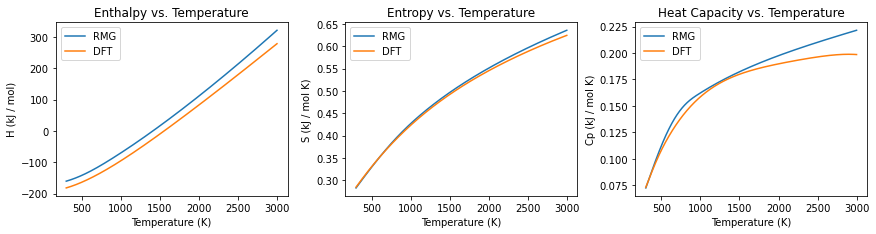

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 92: C1=CCC1(2530)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=2530, label="C1=CCC1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[3.39616,-0.00343655,9.09439e-05,-1.13271e-07,4.24095e-11,17412.4,10.7746], Tmin=(100,'K'), Tmax=(950.25,'K')), NASAPolynomial(coeffs=[9.42761,0.0139641,-4.06873e-06,7.74988e-10,-6.20383e-14,14334.2,-28.181], Tmin=(950.25,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(Cs-(Cds-Cds)CsHH) + group(Cds-CdsCsH) + group(Cds-CdsCsH) + ring(Cyclobutene)"""), molecule=[Molecule(smiles="C1=CCC1")], transport_data=TransportData(shapeIndex=2, epsilon=(3170.39,'J/mol'), sigma=(5.503,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=495.21 K, Pc=43.17 bar (from Joback method)"""), molecular_weight=(54.0904,'amu'))

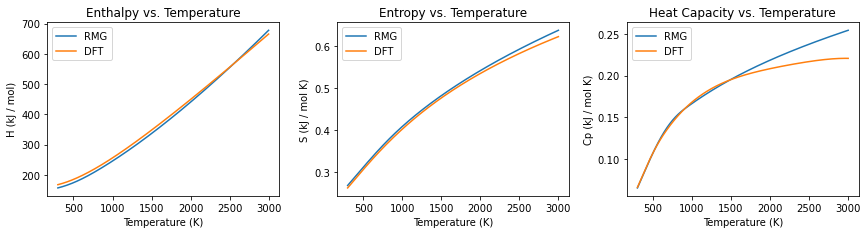

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 96: C1OO1(4213)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=4213, label="C1OO1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[3.54037,-0.0177428,0.000131413,-1.83776e-07,7.77254e-11,-1973.82,7.10205], Tmin=(100,'K'), Tmax=(885.26,'K')), NASAPolynomial(coeffs=[21.1791,-0.0237538,1.674e-05,-3.3921e-09,2.31185e-13,-7984.27,-92.1535], Tmin=(885.26,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(Cs-OsOsHH) + ring(dioxirane)"""), molecule=[Molecule(smiles="C1OO1")], transport_data=TransportData(shapeIndex=2, epsilon=(3011.9,'J/mol'), sigma=(5.143,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=470.45 K, Pc=50.23 bar (from Joback method)"""), molecular_weight=(46.0254,'amu'))

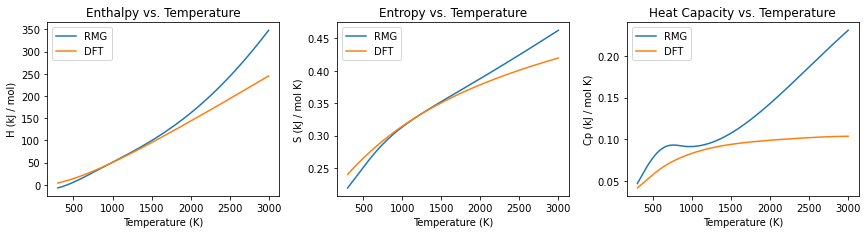

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 101: [C]1CCC1(4880)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=4880, label="[C]1CCC1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[3.16722,0.00609487,6.26547e-05,-7.90235e-08,2.8713e-11,53265.8,21.4596], Tmin=(100,'K'), Tmax=(980.35,'K')), NASAPolynomial(coeffs=[7.14712,0.021075,-8.03253e-06,1.52841e-09,-1.12006e-13,50985.2,-5.31354], Tmin=(980.35,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(CsJ2_singlet-CsH) + ring(Cyclobutane)"""), molecule=[Molecule(smiles="[C]1CCC1")], transport_data=TransportData(shapeIndex=2, epsilon=(4418.31,'J/mol'), sigma=(4.687,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with fixed Lennard Jones Parameters. This is the fallback method! Try improving transport databases!"""), molecular_weight=(54.0904,'amu'))

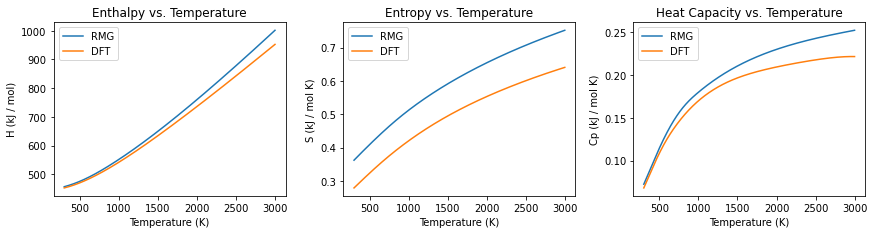

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 102: [CH2]C(CCO)OO(5093)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=5093, label="[CH2]C(CCO)OO", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[0.482183,0.0809041,-8.7673e-05,5.30169e-08,-1.32445e-11,-22864.4,30.0621], Tmin=(100,'K'), Tmax=(959.6,'K')), NASAPolynomial(coeffs=[11.5373,0.0348235,-1.56446e-05,2.97811e-09,-2.08606e-13,-24986.2,-22.817], Tmin=(959.6,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-CsH) + group(O2s-OsH) + group(Cs-CsCsOsH) + group(Cs-CsCsHH) + group(Cs-CsOsHH) +
group(Cs-CsHHH) + radical(CJCOOH)"""), molecule=[Molecule(smiles="[CH2]C(CCO)OO")], transport_data=TransportData(shapeIndex=2, epsilon=(4219.77,'J/mol'), sigma=(7.07,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=659.12 K, Pc=27.1 bar (from Joback method)"""), molecular_weight=(105.113,'amu'))

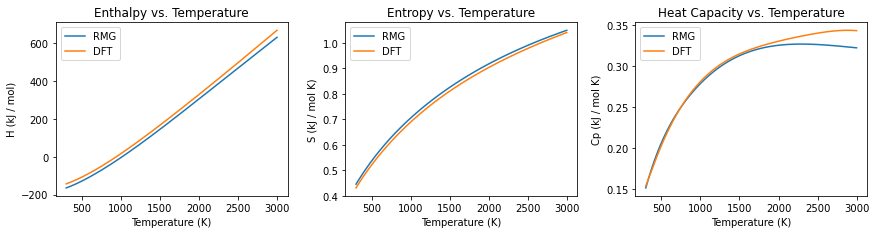

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 103: OCCC1CO1(5151)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=5151, label="OCCC1CO1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[0.72533,0.0580509,-4.82427e-05,2.27152e-08,-4.15793e-12,-34392.8,23.46], Tmin=(100,'K'), Tmax=(1562.93,'K')), NASAPolynomial(coeffs=[11.534,0.0215089,-4.65017e-06,4.85821e-10,-2.07718e-14,-36687,-30.0429], Tmin=(1562.93,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(O2s-CsH) + group(Cs-CsCsOsH) + group(Cs-CsCsHH) + group(Cs-CsOsHH) + group(Cs-CsOsHH) +
ring(Ethylene_oxide)"""), molecule=[Molecule(smiles="OCCC1CO1")], transport_data=TransportData(shapeIndex=2, epsilon=(3801.86,'J/mol'), sigma=(6.458,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=593.84 K, Pc=32.03 bar (from Joback method)"""), molecular_weight=(88.1051,'amu'))

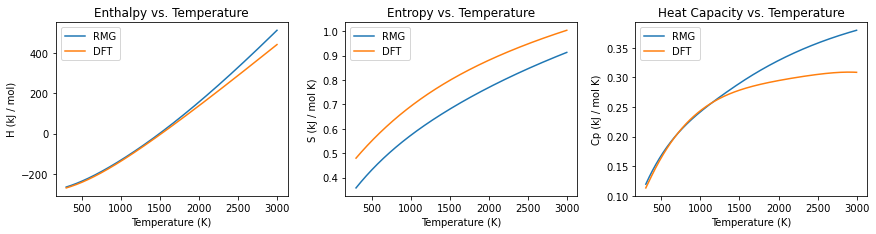

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 105: [CH]1CCOOC1(5425)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=5425, label="[CH]1CCOOC1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[2.1929,0.0236787,5.77757e-05,-9.83426e-08,4.26416e-11,5367.32,18.0956], Tmin=(100,'K'), Tmax=(892.26,'K')), NASAPolynomial(coeffs=[13.3652,0.0164072,-1.9746e-06,7.73586e-11,-1.75745e-15,1669.33,-44.0807], Tmin=(892.26,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(Cs-CsOsHH) + group(Cs-CsOsHH) +
ring(12dioxane) + radical(CCJCOOH)"""), molecule=[Molecule(smiles="[CH]1CCOOC1")], transport_data=TransportData(shapeIndex=2, epsilon=(3705.24,'J/mol'), sigma=(6.42,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=578.75 K, Pc=31.78 bar (from Joback method)"""), molecular_weight=(87.0972,'amu'))

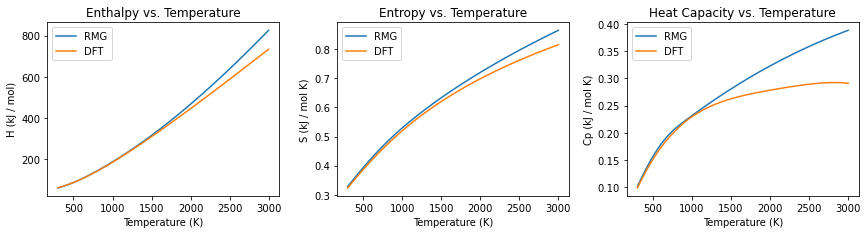

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 107: O=CC1CCO1(5761)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=5761, label="O=CC1CCO1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[2.59469,0.0137283,7.44385e-05,-1.12111e-07,4.68003e-11,-25545.6,18.9058], Tmin=(100,'K'), Tmax=(897.65,'K')), NASAPolynomial(coeffs=[12.6897,0.0138371,-1.0951e-06,-5.11675e-11,5.1862e-15,-29174.7,-38.8259], Tmin=(897.65,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(Cs-(Cds-O2d)CsOsH) + group(Cs-CsCsHH) + group(Cs-CsOsHH) + group(Cds-OdCsH) +
ring(Oxetane)"""), molecule=[Molecule(smiles="O=CC1CCO1")], transport_data=TransportData(shapeIndex=2, epsilon=(3693.51,'J/mol'), sigma=(6.101,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=576.92 K, Pc=36.91 bar (from Joback method)"""), molecular_weight=(86.0892,'amu'))

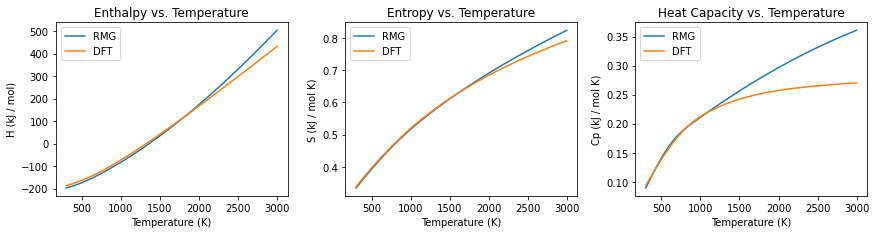

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 108: C1=COOCC1(5951)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=5951, label="C1=COOCC1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[2.33351,0.0205927,5.55329e-05,-9.04591e-08,3.77175e-11,-4469.13,15.0228], Tmin=(100,'K'), Tmax=(923.1,'K')), NASAPolynomial(coeffs=[13.0391,0.0154959,-3.28499e-06,4.79573e-10,-3.54996e-14,-8204.91,-45.2985], Tmin=(923.1,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-O2s(Cds-Cd)) + group(Cs-(Cds-Cds)CsHH) + group(Cs-CsOsHH) + group(Cds-CdsCsH) +
group(Cds-CdsOsH) + ring(34dihydro12dioxin)"""), molecule=[Molecule(smiles="C1=COOCC1")], transport_data=TransportData(shapeIndex=2, epsilon=(3714.62,'J/mol'), sigma=(6.201,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=580.21 K, Pc=35.35 bar (from Joback method)"""), molecular_weight=(86.0892,'amu'))

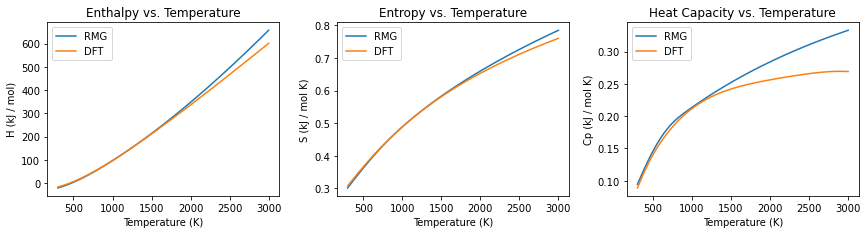

ERROR:root:Cairo not found; molecule will not be drawn.


Changing estimated thermo 109: [O]OC1CCOOC1(9510)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_molecule.png'

Species(index=9510, label="[O]OC1CCOOC1", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[1.01041,0.052766,2.60655e-06,-5.00309e-08,2.68646e-11,-12558.7,23.2208], Tmin=(100,'K'), Tmax=(891.45,'K')), NASAPolynomial(coeffs=[16.1588,0.0208404,-4.32623e-06,5.11978e-10,-2.99424e-14,-16691.8,-56.154], Tmin=(891.45,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(O2s-OsCs) + group(O2s-OsH) + group(Cs-CsCsOsH) + group(Cs-CsCsHH) +
group(Cs-CsOsHH) + group(Cs-CsOsHH) + ring(12dioxane) + radical(ROOJ)"""), molecule=[Molecule(smiles="[O]OC1CCOOC1")], transport_data=TransportData(shapeIndex=2, epsilon=(4332.51,'J/mol'), sigma=(7.189,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=0.0, comment="""Epsilon & sigma estimated with Tc=676.73 K, Pc=26.46 bar (from Joback method)"""), molecular_weight=(119.096,'amu'))

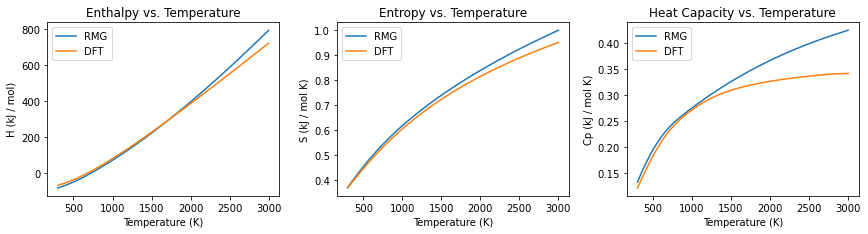

In [17]:
# stitch each of the library thermos into the mechanism

plot_index = [96]

for key in ark_thermo_database.libraries['harris_butane'].entries.keys():
    entry = ark_thermo_database.libraries['harris_butane'].entries[key]
#     print(entry)

    for i, species in enumerate(species_list):
#         if entry.item.is_isomorphic(species.molecule[0]):
        if entry.item.smiles == species.smiles:
            rmg_species_index = i
            break
    else:
        raise ValueError (f'could not match species index {entry}')

    # only change GAV entries
    if 'library' not in species_list[rmg_species_index].thermo.comment.lower():
        print(f'Changing estimated thermo {rmg_species_index}: {species_list[rmg_species_index]}')
        try:
            display(species_list[rmg_species_index])
        except:
            pass
        plot_thermos([species_list[rmg_species_index], entry.data], ['RMG', 'DFT'])
        species_list[rmg_species_index].thermo = entry.data
#         print(rmg_species_index)
        
        
        
    # change everything
#     print(f'Changing estimated thermo {rmg_species_index}: {species_list[rmg_species_index]}')
#     species_list[rmg_species_index].thermo = entry.data
    
    # only change GAV
    
    
#     if rmg_species_index in plot_index:
#         plot_thermos([species_list[rmg_species_index], entry.data], ['RMG', 'DFT'])
#         print(f'Changing estimated thermo {rmg_species_index}: {species_list[rmg_species_index]}')
#         species_list[rmg_species_index].thermo = entry.data

#     break
#     print(species_list[rmg_species_index])
#     print(f'Changing reaction {rmg_rxn_index}')
#     if rmg_rxn_index == 288:
#         reaction_list[rmg_rxn_index].kinetics = entry.data
# #     break
#     # compare the kinetics
#     plot_kinetics([reaction_list[rmg_rxn_index], entry.data], ['RMG', 'DFT'])
    

In [24]:
# # custom save
# chemkin_file = os.path.join(new_model_dir, f'thermo_only.inp')
# rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
# subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={chemkin_file[:-4]}.cti'])
# # os.remove(chemkin_file)


Wrote CTI mechanism file to '/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/thermo_only.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.


CompletedProcess(args=['ck2cti', '--input=/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/thermo_only.inp', '--transport=/work/westgroup/harris.se/autoscience/autoscience/butane/rmg_model/tran.dat', '--output=/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/thermo_only.cti'], returncode=0)

In [16]:
# save the resulting mechanism
timestamp_str = datetime.datetime.now().isoformat()[0:10]
chemkin_file = os.path.join(new_model_dir, f'chem_{timestamp_str}.inp')
rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={new_model_dir}/chem_{timestamp_str}.cti'])
# os.remove(chemkin_file)



Wrote CTI mechanism file to '/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/chem_2022-09-08.cti'.
Mechanism contains 110 species and 1847 reactions.
Validating mechanism...PASSED.


CompletedProcess(args=['ck2cti', '--input=/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/chem_2022-09-08.inp', '--transport=/work/westgroup/harris.se/autoscience/autoscience/butane/rmg_model/tran.dat', '--output=/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/chem_2022-09-08.cti'], returncode=0)

In [ ]:
reaction_list[749].kinetics

In [ ]:
entry.data

In [ ]:
entry.item.is_isomorphic(reaction_list[749])

In [ ]:
dir(entry)

In [ ]:
ark_kinetics_database.libraries[''].entries

In [ ]:
species_list[96].smiles

In [ ]:
for i, rxn in enumerate(reaction_list):
    for sp in rxn.products + rxn.reactants:
        if sp.smiles == species_list[96].smiles:
            print(i, rxn)
            break

In [ ]:
reaction_list[1246].products[0].thermo

In [ ]:
reaction_list[1246].products[0].thermo

In [ ]:
reaction_list[1246].products[0].thermo